In [226]:
import os
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import stdev, mean
import seaborn as sns
import SeabornFig2Grid as sfg
import matplotlib.gridspec as gridspec


def get_hypot(dx,dy):
    hypot = abs(math.sqrt(dx**2 + dy**2))
    return hypot

def plot_nice(df:pd.DataFrame):
    # Clean start
    plt.close('all')

    # Create one figure and one axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Group by 'Direction' and plot each with error bars
    for direction, group in df.groupby('Direction'):
        group = group.sort_values('Time_in_min')
        ax.errorbar(
            group['Time_in_min'],
            group['Mean_px_drift'],
            yerr=group['SE_px_drift'],
            label=direction,
            capsize=3,
            marker='o',
            linestyle='-'
        )

    # Labeling and formatting
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Mean Pixel Drift')
    ax.set_title('Drift over Time by Direction')
    ax.legend(title='Direction')
    ax.grid(True)

    # Show one final plot
    fig.tight_layout()
    plt.show()

    plt.xlabel('Time (min)')
    plt.ylabel('Mean Pixel Drift')
    plt.title('Drift over Time by Direction')
    plt.legend(title='Direction')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def bplot(df:pd.DataFrame, x='Time_in_min'):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=x, y='px_drift')

    plt.xlabel('Time (min)')
    plt.ylabel('Pixel Drift')
    plt.title('Distribution of Pixel Drift by Time')
    plt.xticks(rotation=45)  # Optional: Rotate if too crowded
    plt.tight_layout()
    plt.show()

In [227]:
# Create a table incorporating all cross correlation data tables in subfolders
filename = 'Coord_table_cv2_cross_correlation.csv'

all_data = pd.DataFrame()

# Assign directory
directory = input('Enter parent directory: ')

# Iterate over files in directory
for path, folders, files in os.walk(directory):
    for folder_name in folders:
        if filename in os.listdir(f'{path}/{folder_name}'):
            print(f'Content of {folder_name}')
            with open(f'{path}/{folder_name}/{filename}') as f:
                px_drift = []
                data = pd.read_csv(f)
                print(data)

                for i in range(len(data['Crosscor_tx_px'])):
                    px_drift.append(get_hypot(data['Crosscor_tx_px'][i],data['Crosscor_ty_px'][i]))
                data['px_drift'] = px_drift
                
                all_data = pd.concat([all_data,data]).reset_index(drop=True)
useful_data = all_data[['Direction','Time_in_min','px_drift']].fillna(0)
useful_data.sort_values('Direction')

Content of Align_cross_corr
    Unnamed: 0  ... Crosscor_ty_microm
0            0  ...                NaN
1            1  ...          -0.039062
2            2  ...           0.058594
3            3  ...          -0.019531
4            4  ...          -0.117188
..         ...  ...                ...
94           6  ...           0.214844
95           7  ...          -0.039062
96           8  ...           0.039062
97           9  ...          -0.058594
98          10  ...           0.019531

[99 rows x 16 columns]
Content of Align_cross_corr
    Unnamed: 0  ... Crosscor_ty_microm
0            0  ...                NaN
1            1  ...          -0.214844
2            2  ...          -0.781250
3            3  ...          -0.292969
4            4  ...          -0.664062
..         ...  ...                ...
94           6  ...          -0.234375
95           7  ...           0.136719
96           8  ...          -0.332031
97           9  ...          -0.234375
98          10  ...    

,Direction,Time_in_min,px_drift
712,X_negative,8,0.076158
907,X_negative,5,0.060828
908,X_negative,6,0.058310
909,X_negative,7,0.067082
910,X_negative,8,0.076158
...,...,...,...
1038,Zero,4,0.092195
1039,Zero,5,0.318904
447,Zero,7,0.142127
1042,Zero,8,1.630276


In [228]:
useful_data.to_csv(f'{directory}/drift_data.csv',index=False)

In [229]:
plot_data = []

direction_set = set(useful_data['Direction'].to_list())
for direction in direction_set:
    
    temp = useful_data[useful_data['Direction']==direction] # temporary df of only specific direction

    # find the mean for each Time_in_min
    for minutes in set(temp['Time_in_min'].to_list()):
        min_data = temp[temp['Time_in_min']==minutes] # temp df of only specific time in mins
        values = min_data['px_drift'].to_list()
        plot_data.append([direction,minutes,mean(values),stdev(values)])

plot_data = pd.DataFrame(plot_data, columns=['Direction','Time_in_min','Mean_px_drift','SE_px_drift'])
plot_data = plot_data.sort_values(['Direction','Time_in_min'])

In [230]:
plot_data.to_csv(f'{directory}/mean_drift_data.csv',index=False)

In [231]:
import Function_4_Plot_xy_scatter_grid as f4
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


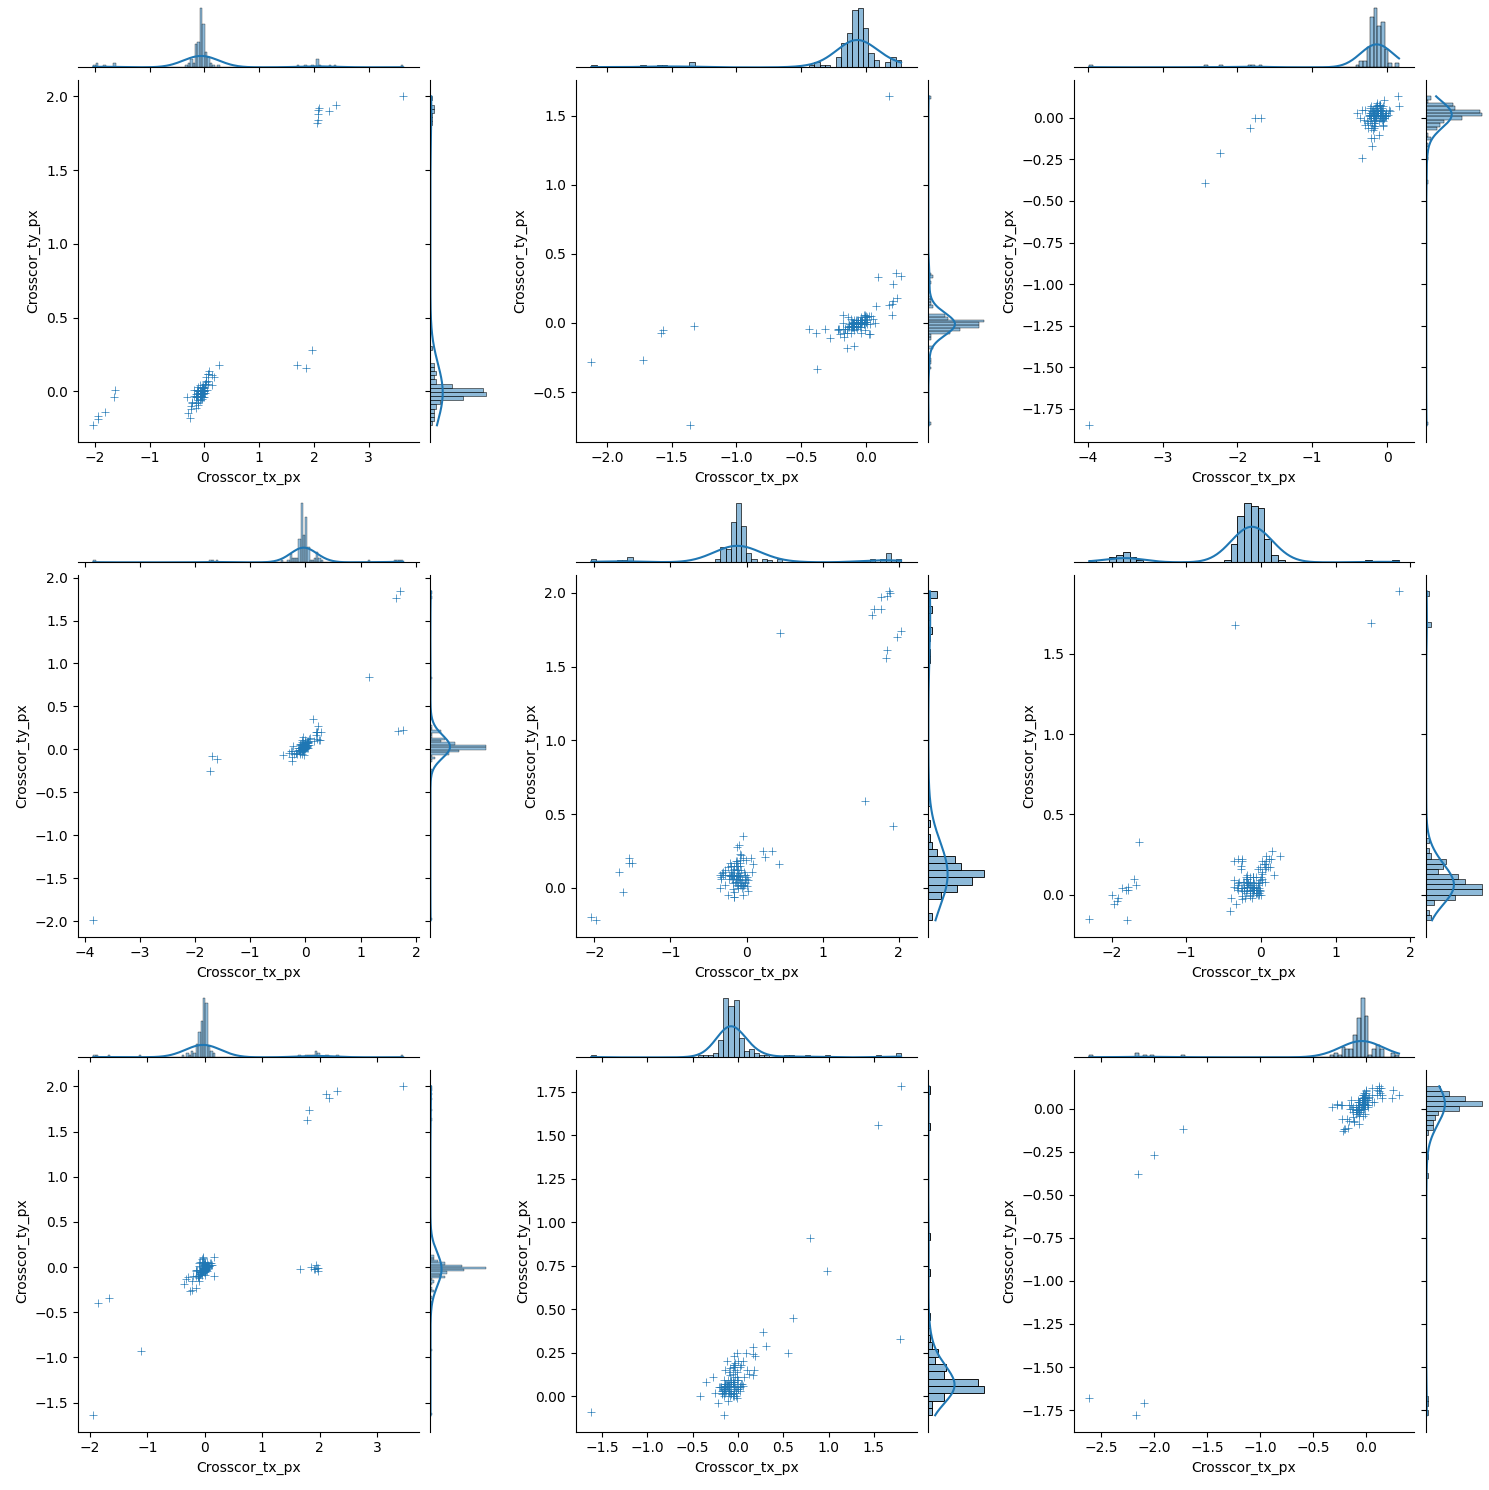

In [232]:
direction_positions = {
    'X_negative_Y_positive': (0, 0),
    'Y_positive':            (0, 1),
    'X_positive_Y_positive': (0, 2),
    'X_negative':            (1, 0),
    'Zero':                  (1, 1),
    'X_positive':            (1, 2),
    'X_negative_Y_negative': (2, 0),
    'Y_negative':            (2, 1),
    'X_positive_Y_negative': (2, 2),
    }

fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(3,3)

groups = all_data.groupby('Direction')
q = 0

for direction, (i,j) in direction_positions.items():
    group = groups.get_group(direction)
    figure = sns.jointplot(data=group,x='Crosscor_tx_px',y='Crosscor_ty_px',dropna=True,marker='+',space=0,marginal_kws=dict(kde=True))
    #figure.ax_marg_x.set_xlim(-10,10)
    #figure.ax_marg_y.set_ylim(-10,10)
    sfg.SeabornFig2Grid(figure, fig, gs[q])

    q += 1

gs.tight_layout(fig)


In [233]:
scale_factor = 1/5.025 #5.025px per 1um

In [284]:
# Adding and fixing data in the table
all_data['Crosscor_tx_microm'] = all_data['Crosscor_tx_px'] * scale_factor
all_data['Crosscor_ty_microm'] = all_data['Crosscor_ty_px'] * scale_factor
all_data['tot_drift_microm'] = all_data['px_drift'] * scale_factor
all_data.rename(columns={'Unnamed: 0': 'img_number'}, inplace=True)
#all_data.drop(columns='Unnamed: 0.1', inplace=True)
all_data['Date'] = all_data['Image_path'].str.extract(r'(\d{4}-\d{2}-\d{2})')
all_data['DateTime'] = all_data['Image_path'].str.extract(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})')

all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'])

In [236]:
all_data

,img_number,Image_path,Image_name,Protocol,ID,Slice_number,X_input_microm,Y_input_microm,Z_input_microm,t,Time_in_min,Direction,Crosscor_tx_px,Crosscor_ty_px,Crosscor_tx_microm,Crosscor_ty_microm,px_drift,tot_drift_microm,Date
0,0,/media/marcus1/large_chungus/data_collection/1...,000_x-4500y-4500z0_t0_m0,long_term_drift,0,1,-4500,-4500,0,0,0,X_negative_Y_negative,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-03
1,1,/media/marcus1/large_chungus/data_collection/1...,001_x-4500y-4500z0_t1_m1,long_term_drift,1,1,-4500,-4500,0,1,1,X_negative_Y_negative,-0.04,-0.02,-0.007960,-0.00398,0.044721,0.008900,2025-06-03
2,2,/media/marcus1/large_chungus/data_collection/1...,002_x-4500y-4500z0_t2_m2,long_term_drift,2,1,-4500,-4500,0,2,2,X_negative_Y_negative,0.00,0.03,0.000000,0.00597,0.030000,0.005970,2025-06-03
3,3,/media/marcus1/large_chungus/data_collection/1...,003_x-4500y-4500z0_t3_m3,long_term_drift,3,1,-4500,-4500,0,3,3,X_negative_Y_negative,-0.02,-0.01,-0.003980,-0.00199,0.022361,0.004450,2025-06-03
4,4,/media/marcus1/large_chungus/data_collection/1...,004_x-4500y-4500z0_t4_m4,long_term_drift,4,1,-4500,-4500,0,4,4,X_negative_Y_negative,-0.06,-0.06,-0.011940,-0.01194,0.084853,0.016886,2025-06-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,6,/media/marcus1/large_chungus/data_collection/1...,094_x4500y4500z0_t6_m6,long_term_drift,94,1,4500,4500,0,6,6,X_positive_Y_positive,-0.16,0.03,-0.031841,0.00597,0.162788,0.032396,2025-06-02
1184,7,/media/marcus1/large_chungus/data_collection/1...,095_x4500y4500z0_t7_m7,long_term_drift,95,1,4500,4500,0,7,7,X_positive_Y_positive,-0.24,0.02,-0.047761,0.00398,0.240832,0.047927,2025-06-02
1185,8,/media/marcus1/large_chungus/data_collection/1...,096_x4500y4500z0_t8_m8,long_term_drift,96,1,4500,4500,0,8,8,X_positive_Y_positive,-0.20,0.04,-0.039801,0.00796,0.203961,0.040589,2025-06-02
1186,9,/media/marcus1/large_chungus/data_collection/1...,097_x4500y4500z0_t9_m9,long_term_drift,97,1,4500,4500,0,9,9,X_positive_Y_positive,-0.19,0.04,-0.037811,0.00796,0.194165,0.038640,2025-06-02


In [285]:
# Save the file
all_data.to_csv(f'{directory}/all_drift_data.csv',index=False)

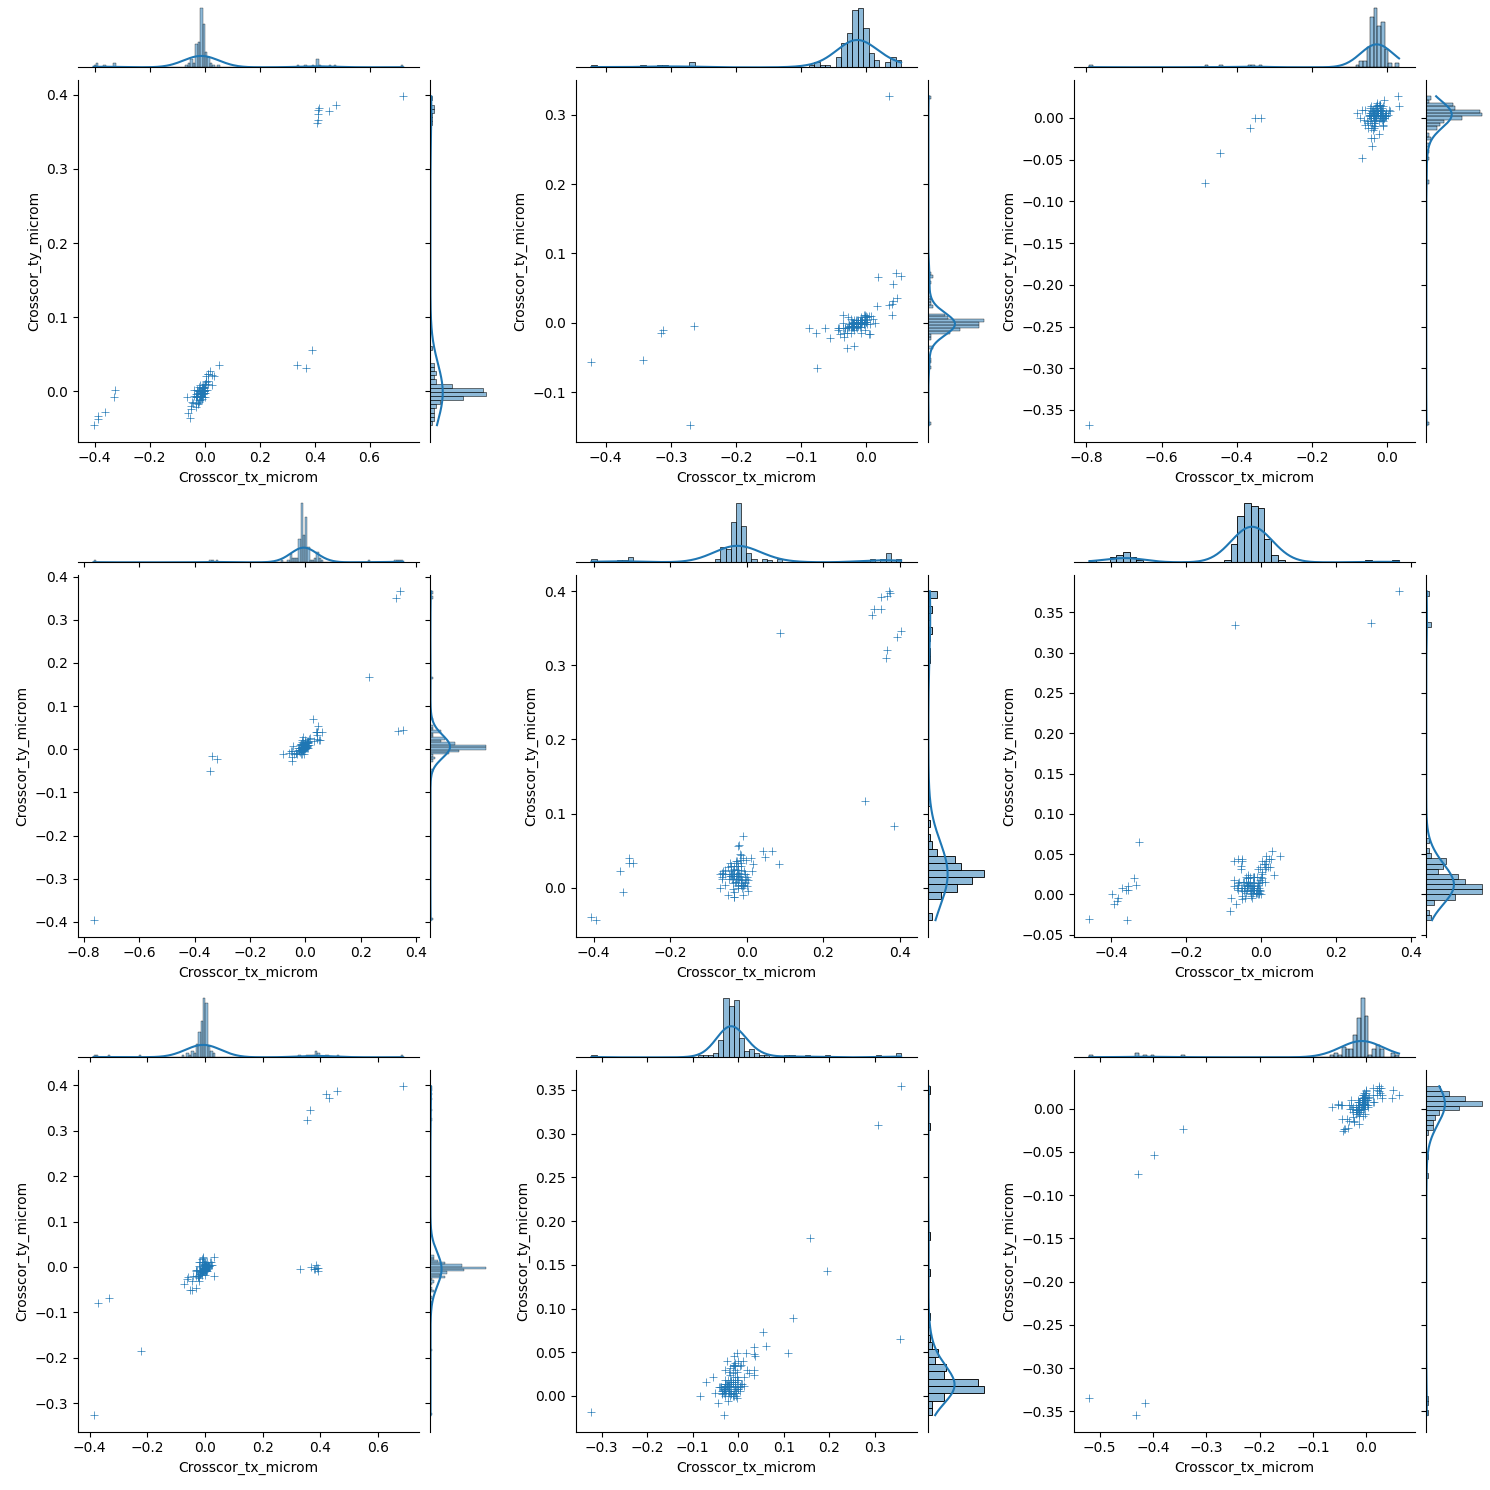

In [238]:
direction_positions = {
    'X_negative_Y_positive': (0, 0),
    'Y_positive':            (0, 1),
    'X_positive_Y_positive': (0, 2),
    'X_negative':            (1, 0),
    'Zero':                  (1, 1),
    'X_positive':            (1, 2),
    'X_negative_Y_negative': (2, 0),
    'Y_negative':            (2, 1),
    'X_positive_Y_negative': (2, 2),
    }

fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(3,3)

groups = all_data.groupby('Direction')
q = 0

for direction, (i,j) in direction_positions.items():
    group = groups.get_group(direction)
    figure = sns.jointplot(data=group,x='Crosscor_tx_microm',y='Crosscor_ty_microm',dropna=True,marker='+',space=0,marginal_kws=dict(kde=True))
    #figure.ax_marg_x.set_xlim(-10,10)
    #figure.ax_marg_y.set_ylim(-10,10)
    sfg.SeabornFig2Grid(figure, fig, gs[q])

    q += 1

gs.tight_layout(fig)


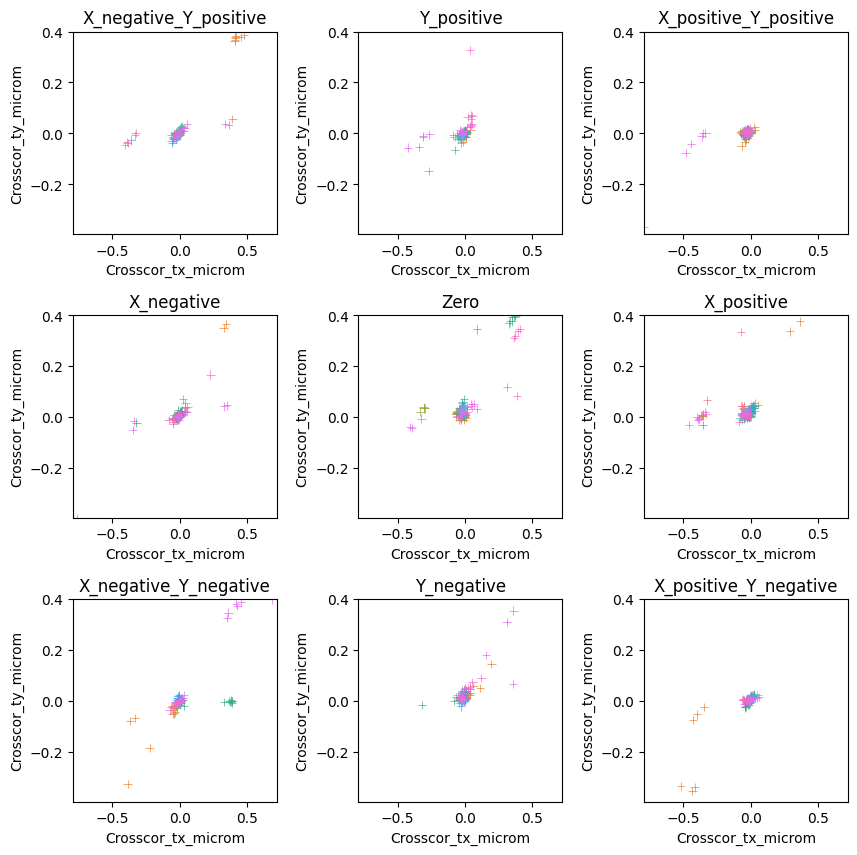

In [302]:
direction_positions = {
    'X_negative_Y_positive': (0, 0),
    'Y_positive':            (0, 1),
    'X_positive_Y_positive': (0, 2),
    'X_negative':            (1, 0),
    'Zero':                  (1, 1),
    'X_positive':            (1, 2),
    'X_negative_Y_negative': (2, 0),
    'Y_negative':            (2, 1),
    'X_positive_Y_negative': (2, 2),
    }

# Create the 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Group data by direction and plot KDEs
for direction, group in all_data.groupby('Direction'):
    if direction not in direction_positions:
        continue  # Skip unknown directions

    i, j = direction_positions[direction]
    ax = axes[i, j]
    sns.scatterplot(
        data=group,
        x='Crosscor_tx_microm', y='Crosscor_ty_microm',
        ax=ax,
        hue='DateTime',
        legend=False,
        marker='+'
    )
    ax.set_title(direction)
    ax.set_xlim(all_data['Crosscor_tx_microm'].min(), all_data['Crosscor_tx_microm'].max())
    ax.set_ylim(all_data['Crosscor_ty_microm'].min(), all_data['Crosscor_ty_microm'].max())



<Axes: xlabel='tot_drift_microm', ylabel='Count'>

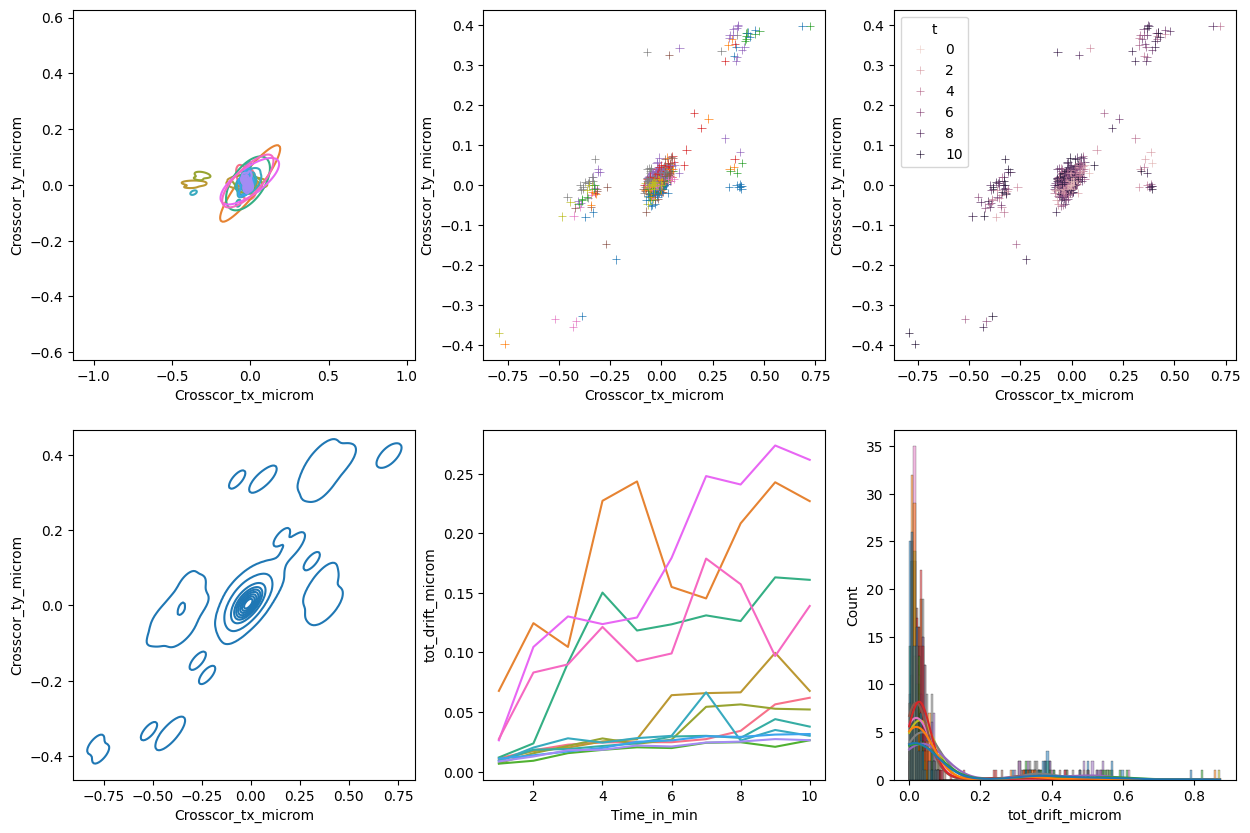

In [341]:
fig, axs = plt.subplots(2,3, figsize=(15,10))

sns.kdeplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',hue='DateTime',ax=axs[0,0],legend=False,thresh=0.01)
sns.scatterplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',hue='Direction',ax=axs[0,1],legend=False,marker='+')
sns.scatterplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',hue='t',ax=axs[0,2],marker='+')
sns.kdeplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',ax=axs[1,0],thresh=0.01)
sns.lineplot(data=all_data,x='Time_in_min',y='tot_drift_microm',hue='DateTime',ax=axs[1,1],legend=False,errorbar=None)
sns.histplot(data=all_data,x='tot_drift_microm',discrete=False,kde=True,hue='Direction',ax=axs[1,2],legend=False)



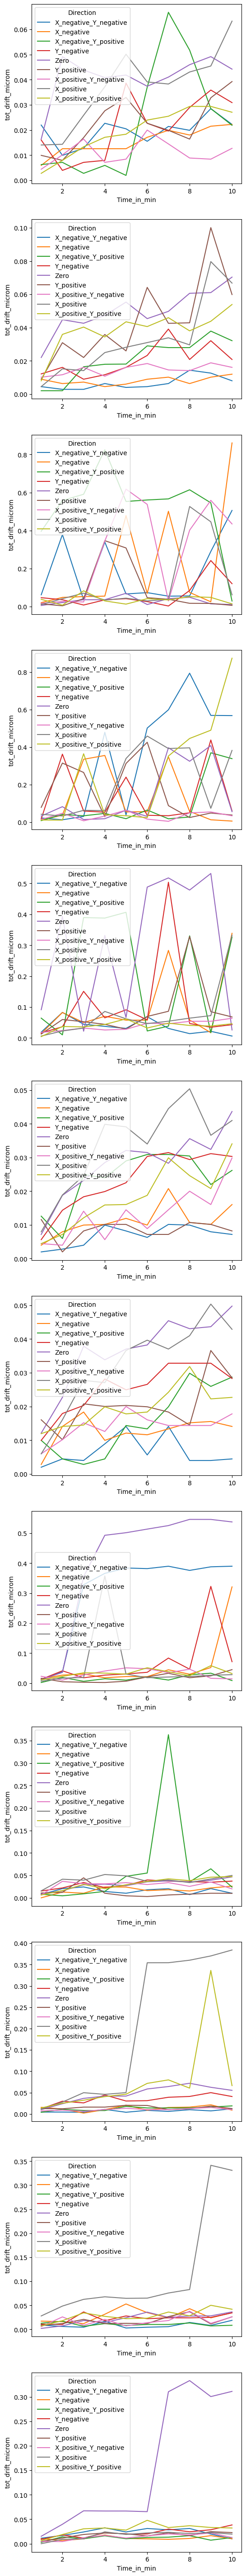

In [356]:
groups = all_data.groupby('DateTime') 
fig, axs = plt.subplots(len(groups),1,figsize = (6,6.1*len(groups)))
for i, (key, group_df) in enumerate(groups):
    sns.lineplot(data=group_df,x='Time_in_min',y='tot_drift_microm',ax=axs[i],errorbar=None,hue='Direction')


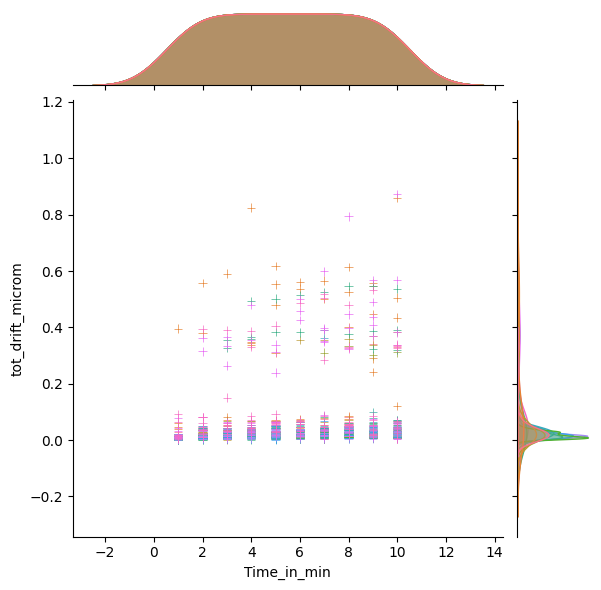

In [290]:
sns.jointplot(data=all_data,x='Time_in_min',y='tot_drift_microm',marker='+',dropna=True,hue='DateTime',legend=False)

<Axes: xlabel='Direction', ylabel='tot_drift_microm'>

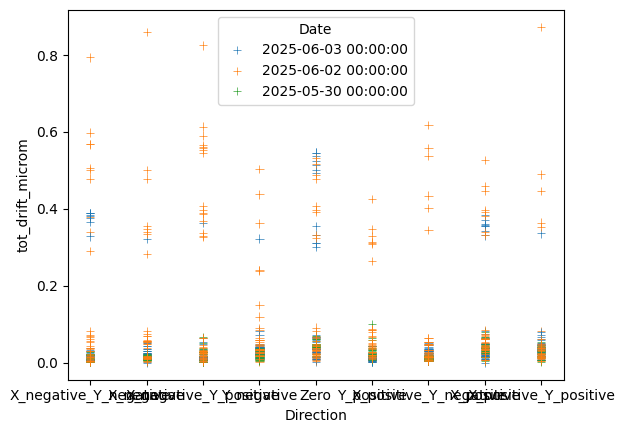

In [242]:
sns.scatterplot(data=all_data,x='Direction',y='tot_drift_microm',marker='+',hue='Date')

(array([-5. , -2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. ]),
 [Text(-5.0, 0, '−5.0'),
  Text(-2.5, 0, '−2.5'),
  Text(0.0, 0, '0.0'),
  Text(2.5, 0, '2.5'),
  Text(5.0, 0, '5.0'),
  Text(7.5, 0, '7.5'),
  Text(10.0, 0, '10.0'),
  Text(12.5, 0, '12.5'),
  Text(15.0, 0, '15.0')])

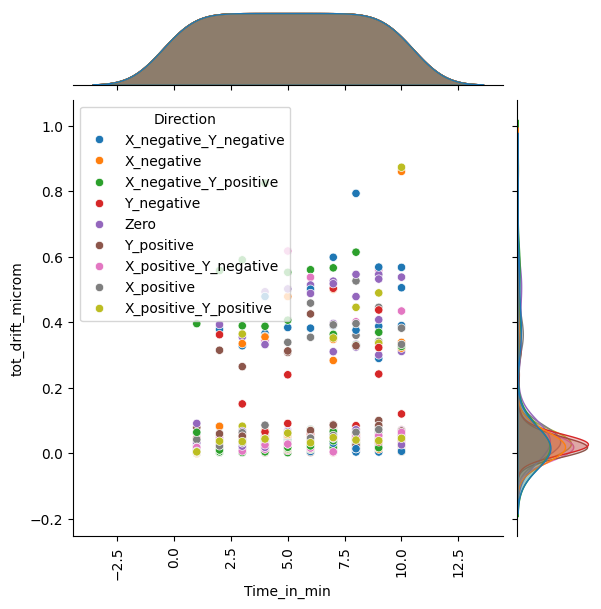

In [252]:
sns.jointplot(data=all_data,x='Time_in_min',y='tot_drift_microm',hue='Direction')
plt.xticks(rotation=90)

<Axes: xlabel='Crosscor_tx_microm', ylabel='Crosscor_ty_microm'>

<Figure size 1000x1000 with 0 Axes>

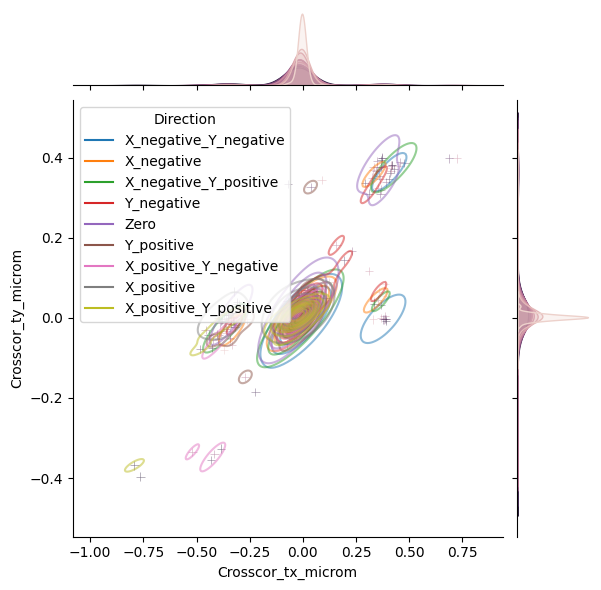

In [267]:
plt.figure(figsize=(10,10))
sns.jointplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',marker='+',alpha=0.5,hue='Time_in_min',dropna=True)
sns.kdeplot(data=all_data,x='Crosscor_tx_microm',y='Crosscor_ty_microm',alpha=0.5,color='r',hue='Direction')